## Final Project - Learning From Recessions

### Team: Amy Rhee, Adam Hamdan, Dev Gupta, Bihong Pei


In [65]:
from course import *
import pandas_datareader as pdr
import numpy as np
from numpy import linalg
from numpy.linalg import inv
from fredapi import Fred
from scipy import signal
fred = Fred(api_key='c85557554fad27f5c130f660ac66a4fc')

## STEP 1. Download, Transform, and Plot Data

### STEP 1.1 Download

Create one pandas dataframe containing the following FRED times series:
- Quarterly dates
- (r_t): NBER recession dates (=1 if recession, 0 otherwise)
- (y_{1t}... y_{nt}): observable economic variables

In [66]:
# Download datasets as pandas dataframe
# (r_t): NBER recession dates (quarterly)
USRECQ = pdr.DataReader("USRECQ", "fred", start = datetime.datetime(1947,1,1),end = datetime.datetime(2050,1,1))
# Real personal income excluding current transfer receipts (quarterly)
PIECTR = pdr.DataReader("PIECTR", "fred", start = datetime.datetime(1947,1,1),end = datetime.datetime(2050,1,1))
# Real personal consumption expenditures (quarterly)
PCECC96 = pdr.DataReader("PCECC96", "fred", start = datetime.datetime(1947,1,1),end = datetime.datetime(2050,1,1))
# Real GDP (quarterly)
GDPC1 = pdr.DataReader("GDPC1", "fred", start = datetime.datetime(1947,1,1),end = datetime.datetime(2050,1,1))
# Real GDI (quarterly)
A261RX1Q020SBEA = pdr.DataReader("A261RX1Q020SBEA", "fred", start = datetime.datetime(1947,1,1),end = datetime.datetime(2050,1,1))
# Real Average GDP and GDI (quarterly)
LB0000091Q020SBEA = pdr.DataReader("LB0000091Q020SBEA", "fred", start = datetime.datetime(1947,1,1),end = datetime.datetime(2050,1,1))
# All Employees, Total Nonfarm (monthly)
PAYEMS = pdr.DataReader("PAYEMS", "fred", start = datetime.datetime(1947,1,1),end = datetime.datetime(2050,1,1))
# Employment Level (monthly)
CE16OV = pdr.DataReader("CE16OV", "fred", start = datetime.datetime(1947,1,1),end = datetime.datetime(2050,1,1))
# Industrial production total index (monthly)
INDPRO = pdr.DataReader("INDPRO", "fred", start = datetime.datetime(1947,1,1),end = datetime.datetime(2050,1,1))
# Real Manufacturing and Trade Industries Sales, adjusted for price changes (monthly)
CMRMTSPL = pdr.DataReader("CMRMTSPL", "fred", start = datetime.datetime(1947,1,1),end = datetime.datetime(2050,1,1))
# create dataframe for quarterly variables
df_quarterly = pd.concat([USRECQ, PIECTR, PCECC96, GDPC1, A261RX1Q020SBEA, LB0000091Q020SBEA],axis=1,join="inner")
df_quarterly = df_quarterly.reset_index()
df_quarterly['DATE'] = pd.to_datetime(df_quarterly['DATE'])
df_quarterly = df_quarterly.groupby(df_quarterly['DATE'].dt.to_period('Q')).sum()
# convert monthly datasets into quarterly
# create dataframe for monthly variables
df_monthly = pd.concat([PAYEMS, CE16OV, INDPRO, CMRMTSPL],axis=1,join="inner")
df_monthly = df_monthly.reset_index()
df_monthly['DATE'] = pd.to_datetime(df_monthly['DATE'])
# convert into quarterly averages
df_new = df_monthly.groupby(df_monthly['DATE'].dt.to_period('Q')).mean().round()
# merge dataframes together
df = pd.concat([df_quarterly, df_new],axis=1,join="inner")
# rename columns to readable names
df = df.rename(columns={"USRECQ": "nber_recessions",
                        "PIECTR": "real_personal_income_less_transfers",
                        "PCECC96": "real_pce",
                        "GDPC1": "real_gdp",
                        "A261RX1Q020SBEA": "real_gdi",
                        "LB0000091Q020SBEA": "real_avg_gdp_gdi",
                        "PAYEMS": "total_nonfarm_emp",
                        "CE16OV": "emp_level",
                        "INDPRO": "industrial_prod_index",
                        "CMRMTSPL": "real_manuf_trade_sales"})
# look at our pretty dataframe
# df.head()

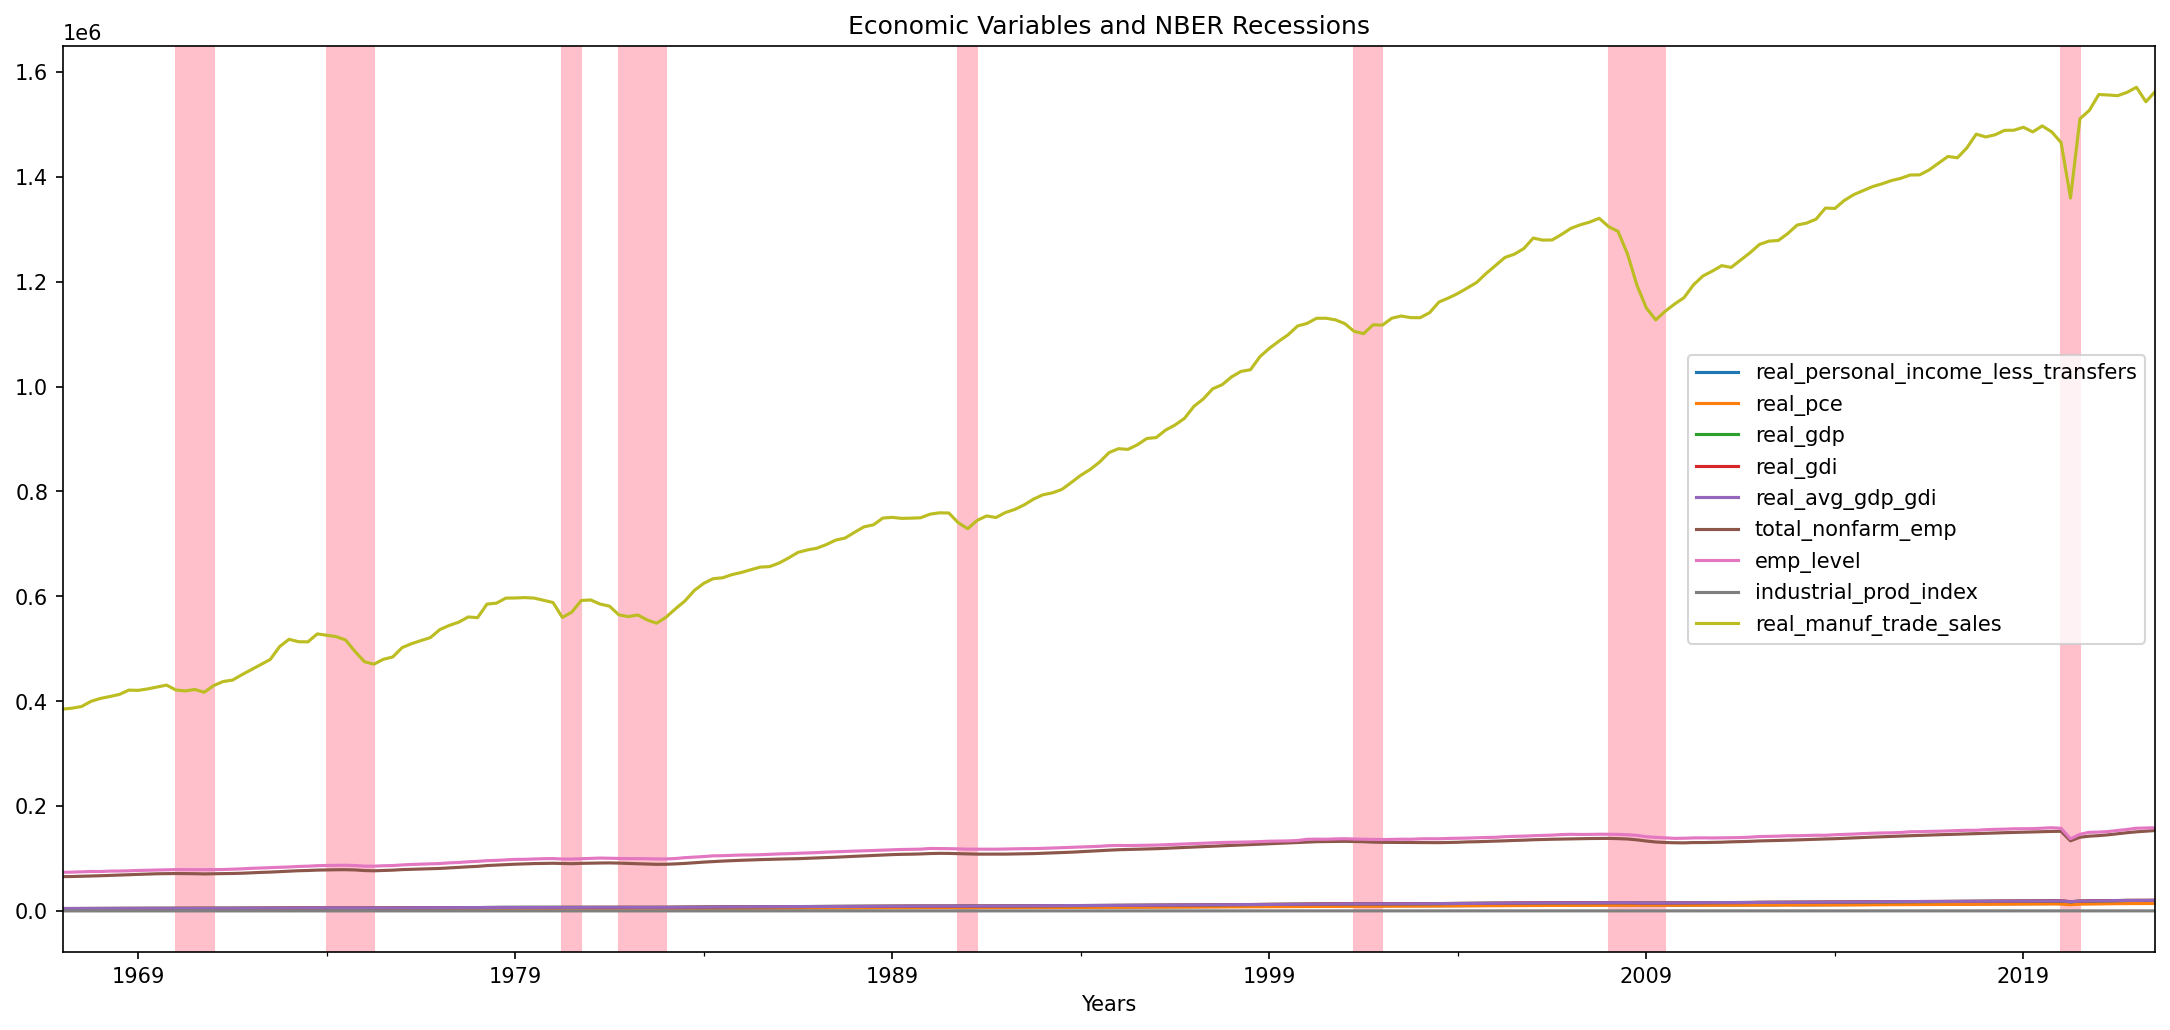

In [67]:
# Plot everything so we know what we're dealing with
plt.figure(figsize=(18, 8), dpi=150)
df['real_personal_income_less_transfers'].plot(label='real_personal_income_less_transfers')
df['real_pce'].plot(label='real_pce')
df['real_gdp'].plot(label='real_gdp')
df['real_gdi'].plot(label='real_gdi')
df['real_avg_gdp_gdi'].plot(label='real_avg_gdp_gdi')
df['total_nonfarm_emp'].plot(label='total_nonfarm_emp')
df['emp_level'].plot(label='emp_level')
df['industrial_prod_index'].plot(label='industrial_prod_index')
df['real_manuf_trade_sales'].plot(label='real_manuf_trade_sales')

# adding title to the plot
plt.title('Economic Variables and NBER Recessions')
  
# adding Label to the x-axis
plt.xlabel('Years')

# Adding shaded recessions
ilist = list(range(len(df['nber_recessions'])))
for i in range(len(df['nber_recessions'])):
    if df['nber_recessions'].iloc[i] == 1:
        plt.axvspan(df.index[i], df.index[i+1], color = 'pink')
        

# adding legend to the curve
plt.legend()
plt.show()

### STEP 1.2 Transform our data to make meaningful comparisons:

For each covariate y_ti, get the quarterly annualized (logarithmic) growth rate

In [68]:
# Compute quarterly annualized (logarithmic) growth rate
df['log_real_personal_income_less_transfers'] = 4*np.log(df['real_personal_income_less_transfers'].pct_change(periods=1) + 1)
df['log_real_pce'] = 4*np.log(df['real_pce'].pct_change(periods=1) + 1)
df['log_real_gdp'] = 4*np.log(df['real_gdp'].pct_change(periods=1) + 1)
df['log_real_gdi'] = 4*np.log(df['real_gdi'].pct_change(periods=1) + 1)
df['log_real_avg_gdp_gdi'] = 4*np.log(df['real_avg_gdp_gdi'].pct_change(periods=1) + 1)
df['log_total_nonfarm_emp'] = 4*np.log(df['total_nonfarm_emp'].pct_change(periods=1) + 1)
df['log_emp_level'] = 4*np.log(df['emp_level'].pct_change(periods=1) + 1)
df['log_industrial_prod_index'] = 4*np.log(df['industrial_prod_index'].pct_change(periods=1) + 1)
df['log_real_manuf_trade_sales'] = 4*np.log(df['real_manuf_trade_sales'].pct_change(periods=1) + 1)

# see our new dataframe
df.head()

df.to_csv('logged_data.csv')


### STEP 1.3 Plot Our New Time Series Data

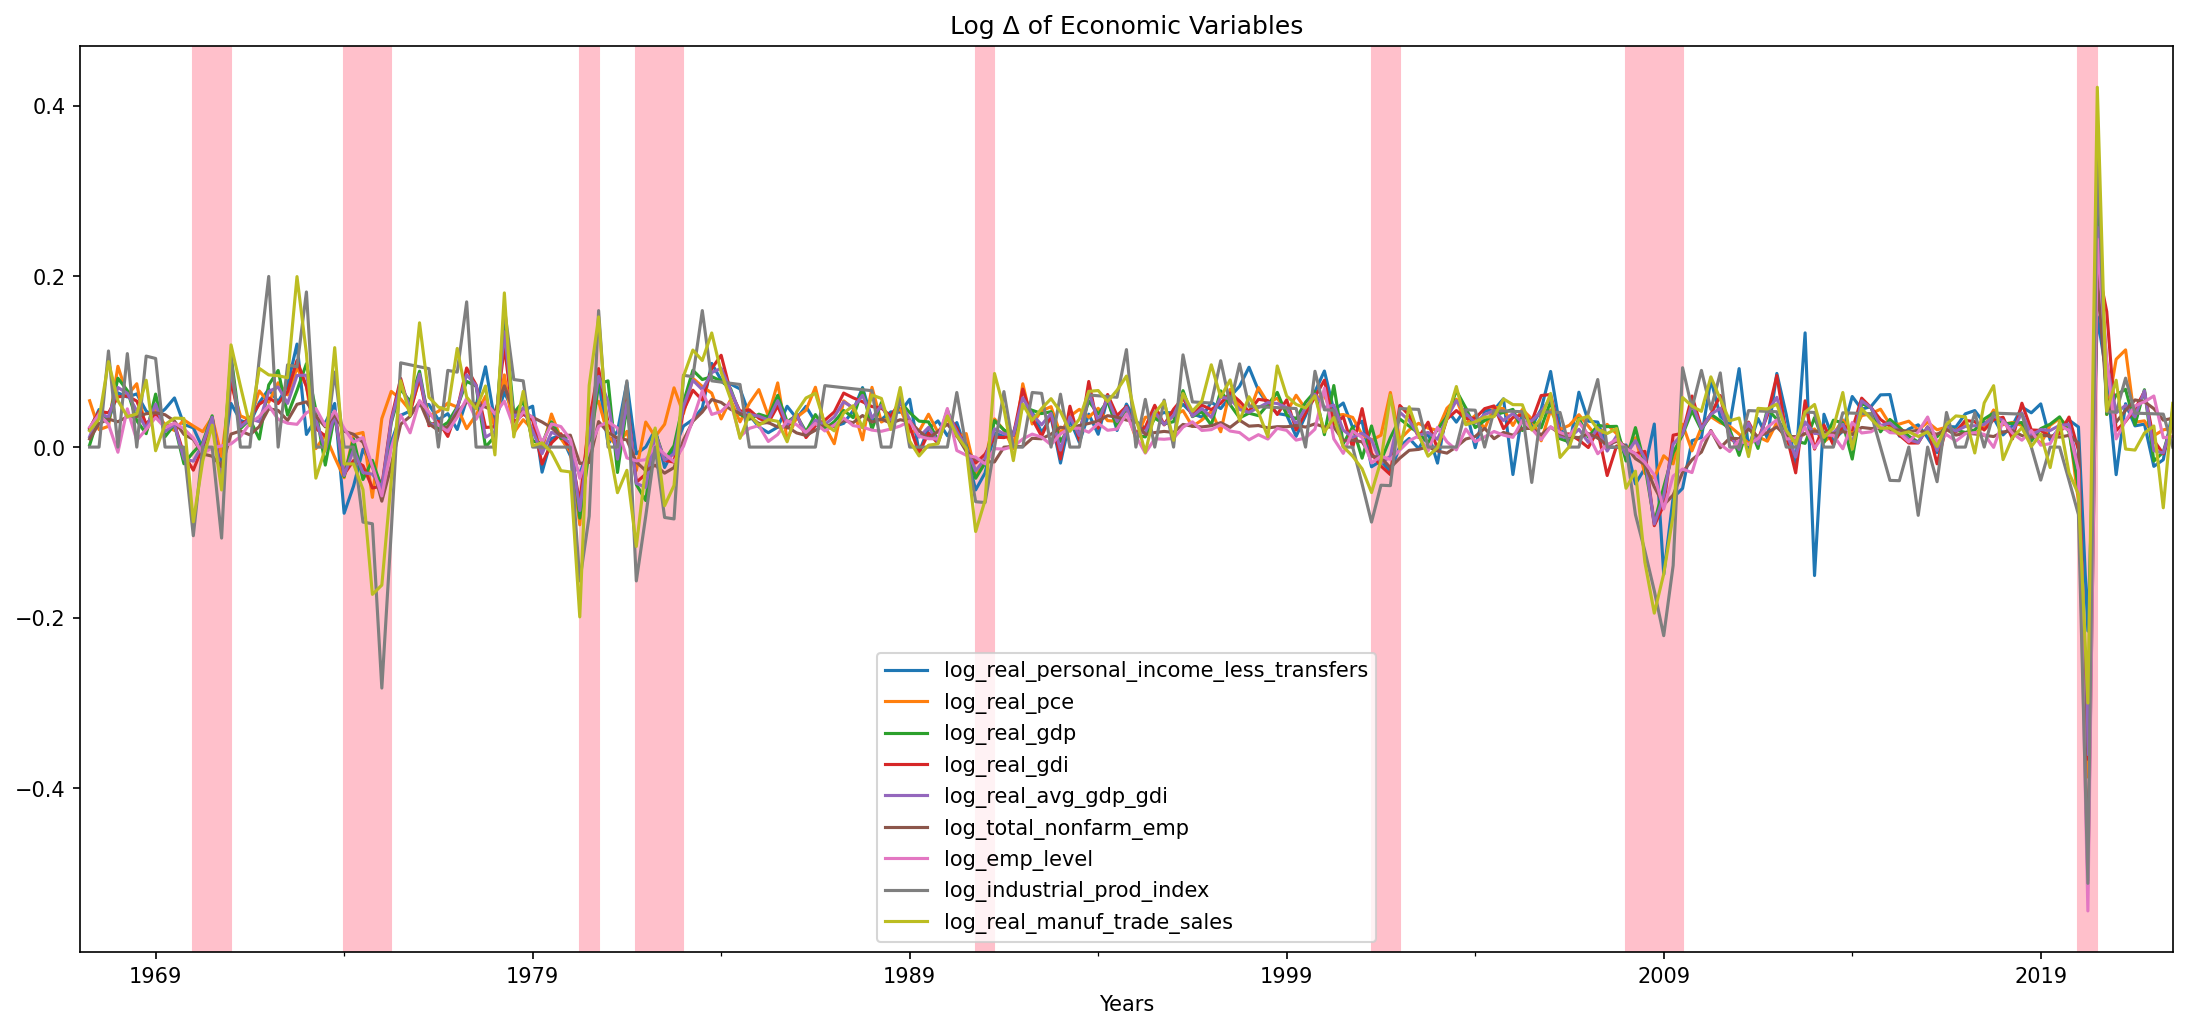

In [69]:
# Plot everything so we know what we're dealing with
plt.figure(figsize=(18, 8), dpi=150)
  
# in plot method we set the label and color of the curve.
# df['nber_recessions'].plot(label='NBER_recessions', color='orange')
df['log_real_personal_income_less_transfers'].plot(label='log_real_personal_income_less_transfers')
df['log_real_pce'].plot(label='log_real_pce')
df['log_real_gdp'].plot(label='log_real_gdp')
df['log_real_gdi'].plot(label='log_real_gdi')
df['log_real_avg_gdp_gdi'].plot(label='log_real_avg_gdp_gdi')
df['log_total_nonfarm_emp'].plot(label='log_total_nonfarm_emp')
df['log_emp_level'].plot(label='log_emp_level')
df['log_industrial_prod_index'].plot(label='log_industrial_prod_index')
df['log_real_manuf_trade_sales'].plot(label='log_real_manuf_trade_sales')

# adding title to the plot
plt.title('Log Δ of Economic Variables')
  
# adding Label to the x-axis
plt.xlabel('Years')

# Adding shaded recessions
ilist = list(range(len(df['nber_recessions'])))
for i in range(len(df['nber_recessions'])):
    if df['nber_recessions'].iloc[i] == 1:
        plt.axvspan(df.index[i], df.index[i+1], color = 'pink')
        
# plt.xlim([0.01, df['nber_recessions'].shape[0]])
  
# adding legend to the curve
plt.legend()
plt.show()

In [71]:
def plot(data, nvar, legend_loc='center right'):
    for i in range(nvar):
        d = np.array( data.T.iloc[[i]].T )
        plt.plot(d)
    plt.legend(data.keys(), loc=legend_loc,prop={'size': 7})

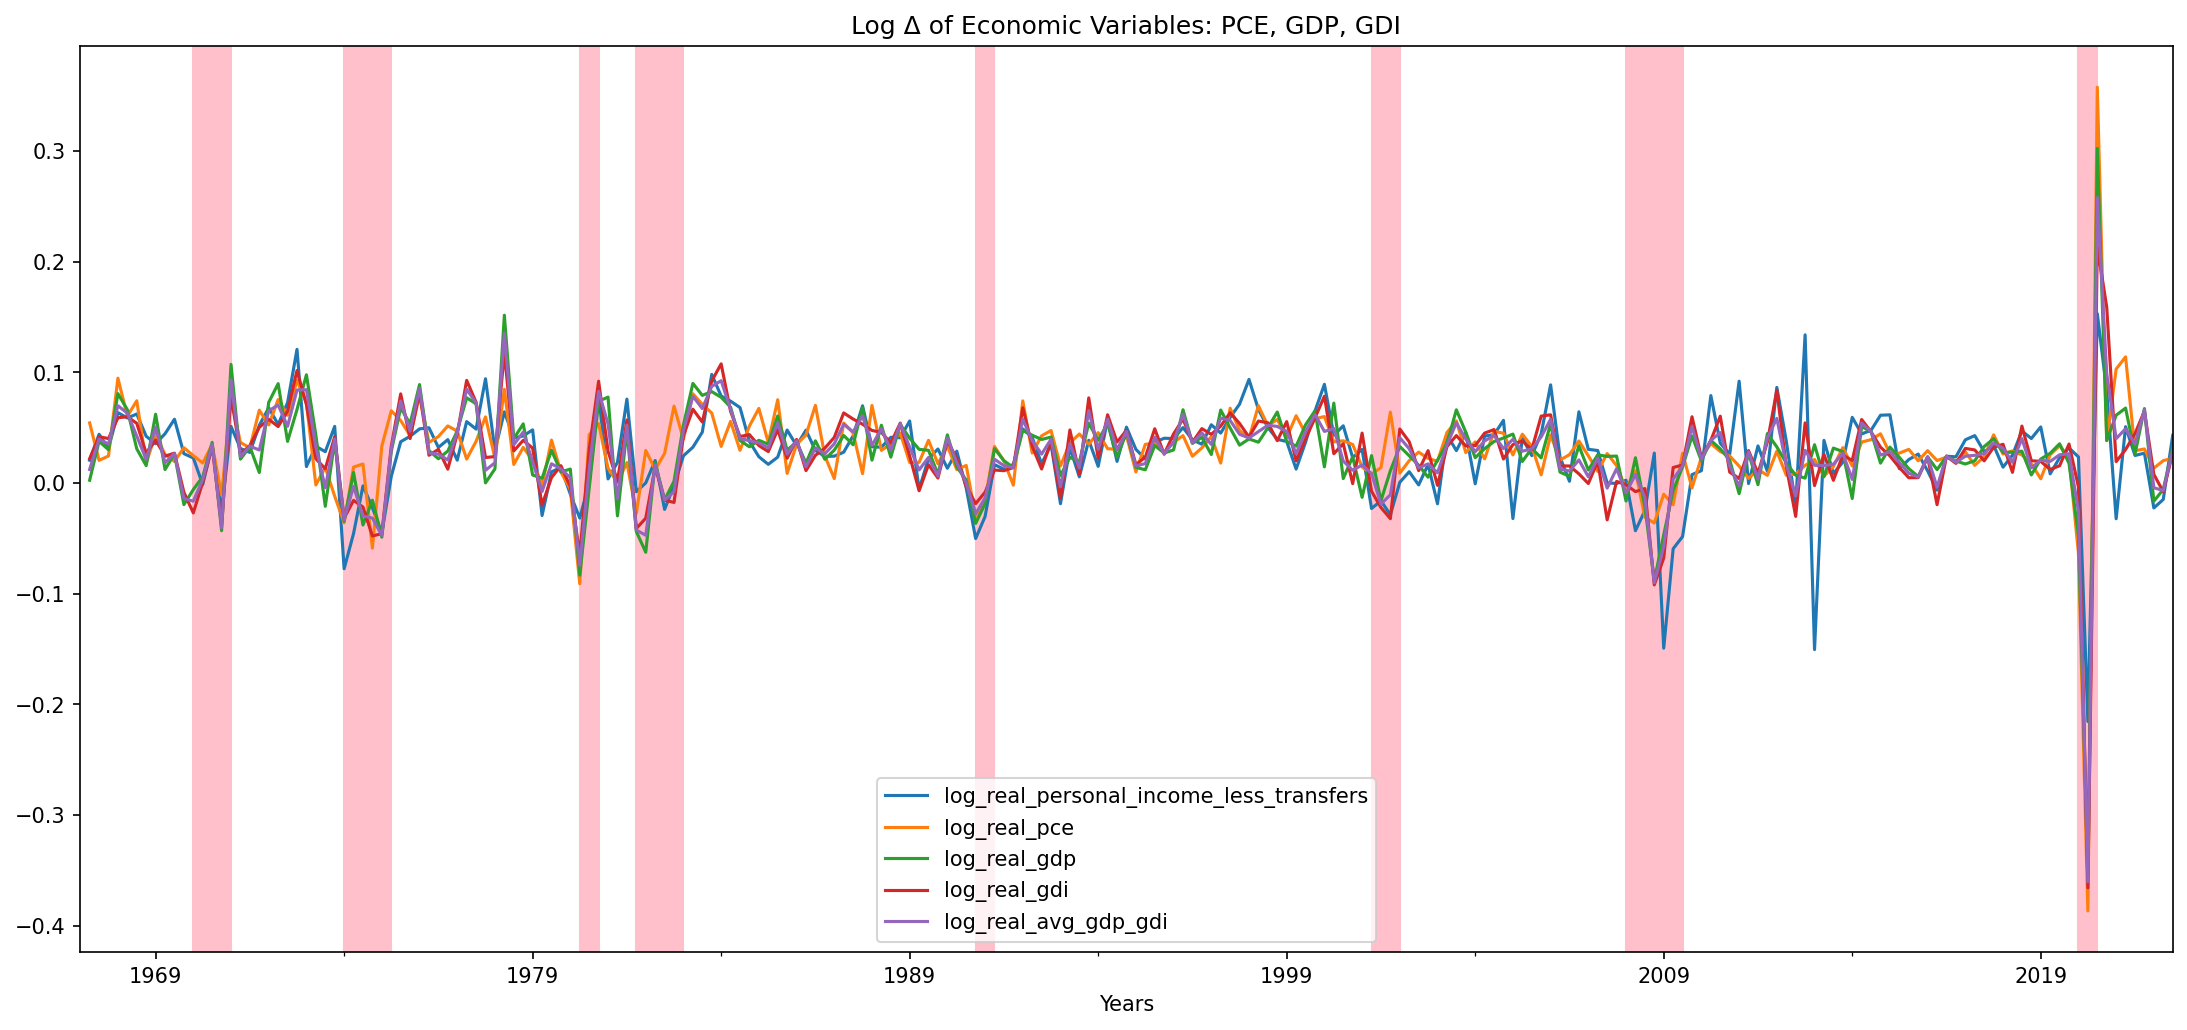

In [72]:
# Plot subsets of covariates
plt.figure(figsize=(18, 8), dpi=150)
  
# in plot method we set the label and color of the curve.
# df['nber_recessions'].plot(label='NBER_recessions', color='orange')
df['log_real_personal_income_less_transfers'].plot(label='log_real_personal_income_less_transfers')
df['log_real_pce'].plot(label='log_real_pce')
df['log_real_gdp'].plot(label='log_real_gdp')
df['log_real_gdi'].plot(label='log_real_gdi')
df['log_real_avg_gdp_gdi'].plot(label='log_real_avg_gdp_gdi')
# df['log_total_nonfarm_emp'].plot(label='log_total_nonfarm_emp')
# df['log_emp_level'].plot(label='log_emp_level')
# df['log_industrial_prod_index'].plot(label='log_industrial_prod_index')
# df['log_real_manuf_trade_sales'].plot(label='log_real_manuf_trade_sales')

# adding title to the plot
plt.title('Log Δ of Economic Variables: PCE, GDP, GDI')
  
# adding Label to the x-axis
plt.xlabel('Years')

# Adding shaded recessions
ilist = list(range(len(df['nber_recessions'])))
for i in range(len(df['nber_recessions'])):
    if df['nber_recessions'].iloc[i] == 1:
        plt.axvspan(df.index[i], df.index[i+1], color = 'pink')

plt.legend()
plt.show()

Observation: Might end up having a multicollinearity problem if we use all covariates, since they seem to be sorta ''clustered'' where they're just shifts of each other in a given cluster

### STEP 2. Use Kalman Filter to get $\hat{x}_t$

In [73]:
import numpy as np
from numpy import linalg

### Declaring class and methods

##### Methods: 
1. ``forecast``: produces $\hat{x}_t, \hat{\Sigma}$ via Kalman filter procedure
2. ``rhat_fn``: produces $\hat{r}_t$ with $R  = \gamma \mathbb{E}[\hat{x}_t]$, where by $\gamma$ is a tuning parameter and by default $\gamma = 0.5$
3. ``plot_fig``: plots estimated $\hat{x}_t$
4. ``calc_err``: calculates sum of absolute differences (and squared by default, since values are either 1 or 0) between true $r_t$ and ``rhat_fn`` output $\hat{r}_t$ 

In [74]:
class Kalman:
    def __init__(self, x0, sigma0, A, C, G, R, y):
        self.x0 = x0
        self.sigma0 = sigma0
        self.A = A
        self.C = C
        self.G = G
        self.R = R
        self.y = y
        
    def forecast(self):
        T = len(y)
        xhat = np.zeros((T,1))
        xhat[0] = self.x0
        sigmahat = np.zeros((T,1))
        sigmahat[0] = self.sigma0
        for t in range(T-1):
            a_t = self.y[t] - self.G@xhat[t]
            K_t = self.A @ sigmahat[t] @ self.G.T @ linalg.inv(( linalg.multi_dot((self.G, sigmahat[t][0])) @ self.G.T) + self.R)
            sigmahat[t+1] = (self.A - K_t @ self.G)@sigmahat[t]@(self.A - K_t @ self.G).T + self.C@self.C.T + K_t@self.R@K_t.T
            xhat[t+1] =  self.A @ xhat[t] + K_t @ a_t
        self.xhat = xhat
        self.sigmahat = sigmahat
        return self.xhat, self.sigmahat
    
    def rhat_fn(self, gamma=0.6):
        self.forecast()
        r = df['nber_recessions']
        rhat = np.zeros((len(self.xhat),1))
        
        for i in range(len(self.xhat)):
            if self.xhat[i] < (self.xhat.mean() - gamma*self.xhat.std()):
                rhat[i] = 1
        self.rhat = rhat    
        return rhat
    
    def plot_fig(self, title_name='', line_col='black', yaxis_limits=[-0.25, 0.2], plot_rhat=''):
        plt.figure(figsize=(18, 8), dpi=150)
        if plot_rhat == True:
            self.rhat_fn()
            ilist = list(range(len(self.rhat)))
            for i in range(len(self.rhat)-1):
                if self.rhat[i] == 1:
                    plt.axvline(ilist[i], color = 'lightsteelblue', alpha=1)
                    if self.rhat[i] == 1 and self.rhat[i+1] == 1:
                        y = np.arange(-0.5, 0.5, 0.01)
                        plt.fill_betweenx(y, ilist[i], ilist[i+1], color = 'lightsteelblue', alpha=1)
        
        ilist = list(range(df['nber_recessions'].shape[0]))
        for i in range(df['nber_recessions'].shape[0]):
            if df['nber_recessions'][i] == 1:
                plt.axvline(ilist[i], color = 'pink', alpha=0.5)
                if df['nber_recessions'][i] == 1 and df['nber_recessions'][i+1] == 1:
                    y = np.arange(-0.5, 0.5, 0.01)
                    plt.fill_betweenx(y, ilist[i], ilist[i+1], color = 'pink', alpha=0.5)
        
        self.forecast()
        plt.plot(self.xhat, color=line_col)
        plt.axhline(self.xhat.mean(), label = 'mean', color=line_col, alpha=0.5)
        plt.legend(loc='upper left')
        plt.xlim([0.01, df['nber_recessions'].shape[0]])
        plt.ylim(yaxis_limits)
        plt.title(title_name)
        plt.show()
    
    def calc_err(self):
        self.rhat_fn()
        r = df['nber_recessions'][1:].to_numpy()
        err_vec = abs(r-self.rhat)
        self.err = err_vec
        return self.err
        

#### First construct $Y$ using all (logged) covariates 

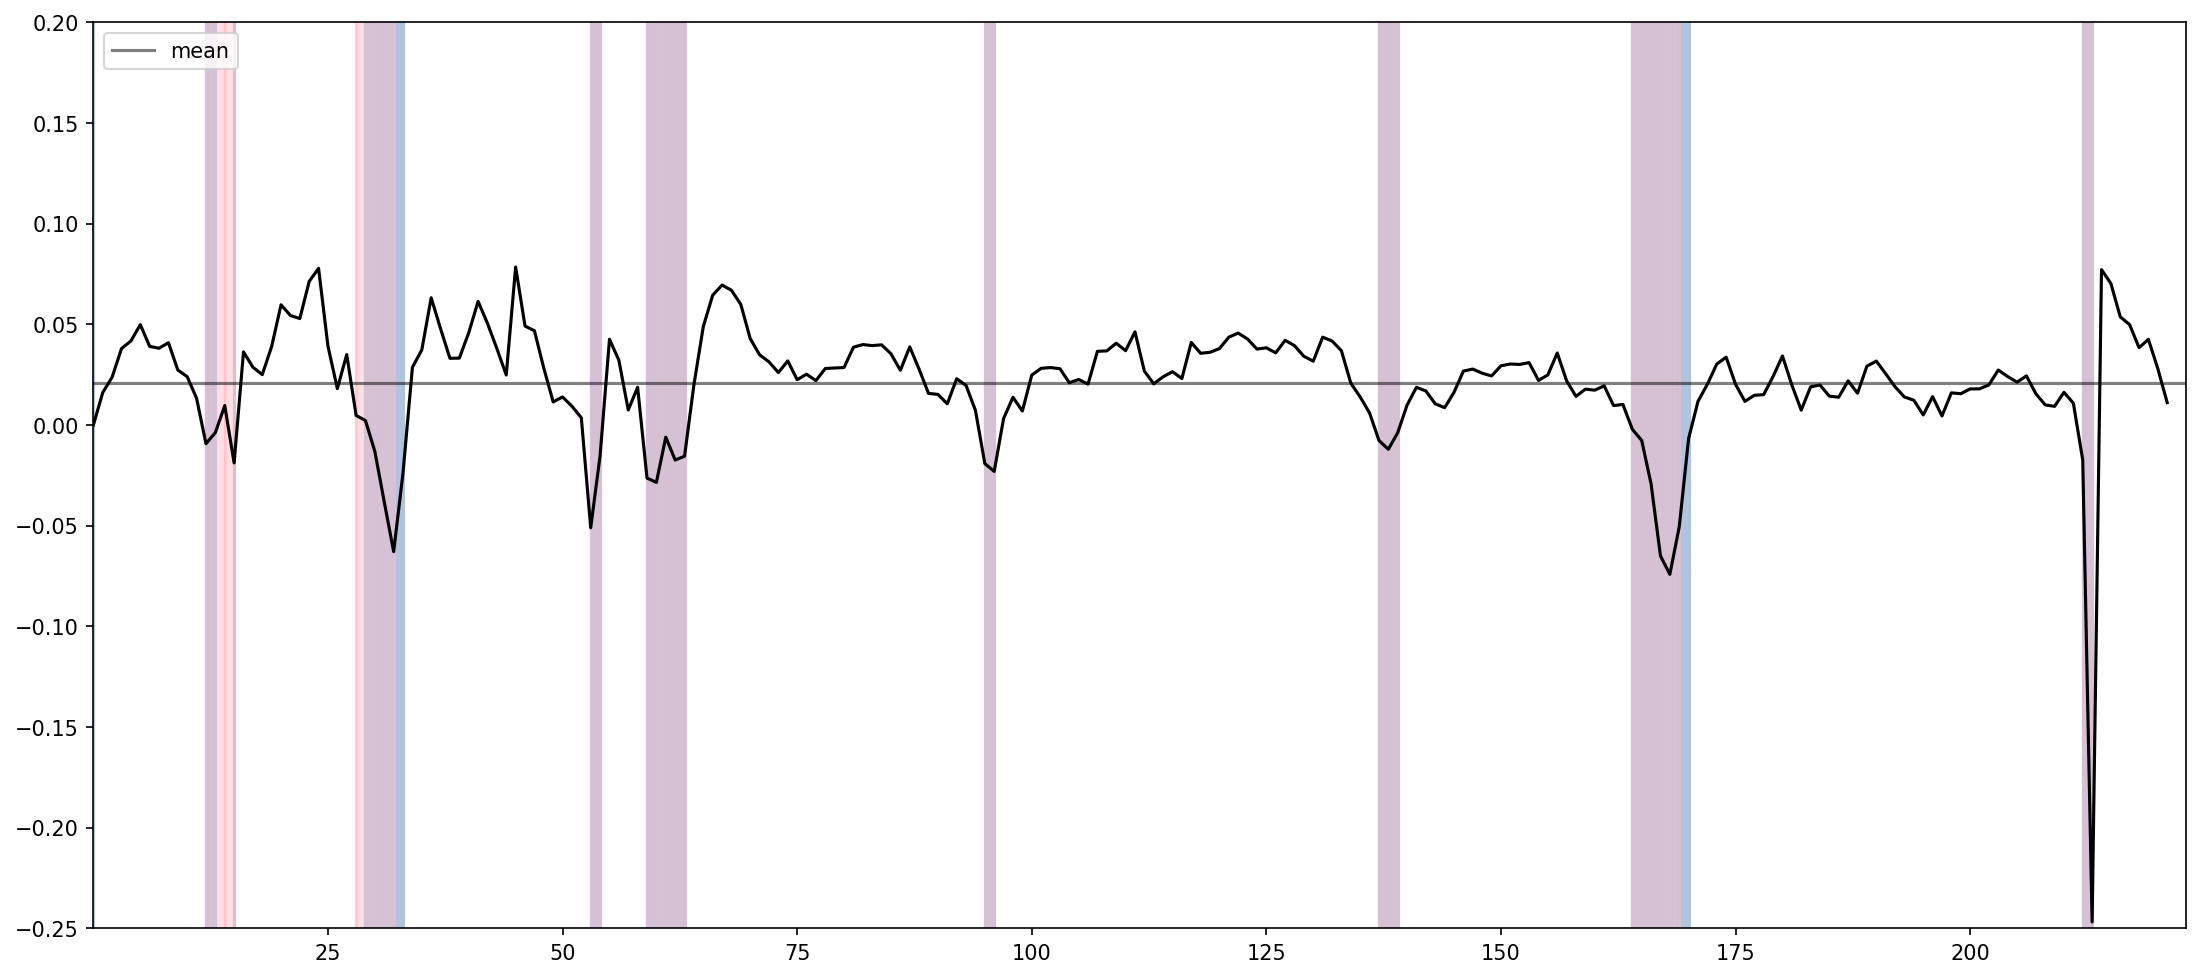

In [75]:
# ALL COVARIATES
allvars = df.copy()
allvars = df[['log_real_personal_income_less_transfers', 'log_real_pce',
       'log_real_gdp', 'log_real_gdi', 'log_real_avg_gdp_gdi',
       'log_total_nonfarm_emp', 'log_emp_level', 'log_industrial_prod_index',
       'log_real_manuf_trade_sales']]
allvars = allvars.to_numpy()
allvars = np.delete(allvars, 0, 1)
allvars = np.delete(allvars, 0, 0) # First row NaNs!
y = allvars

G = np.ones((y.shape[1],1)) # vector of ones (k x 1)
x0 = np.array([[0]]) # n x 1 (so n = 1; scalar)
rho = np.array([[0.95]]) # n x 1 (scalar)
C = np.array([[0.05]]) # n x m (n=1 and chose m=1), where m is dimensionality of error term
R = 0.02*np.eye(y.shape[1]) # k x k 
sigma0 = np.array([[0.05]]) # n x n (so scalar)

allvars_k = Kalman(x0, sigma0, rho, C, G, R, y)
allvars_m, allvars_v = allvars_k.forecast()
# allvars_k.rhat_fn(gamma=1)
allvars_k.plot_fig(plot_rhat=True) 


In [53]:
# plt.figure(figsize=(18, 8), dpi=150)
# ilist = list(range(df['nber_recessions'].shape[0]))
# for i in range(df['nber_recessions'].shape[0]):
#     if df['nber_recessions'][i] == 1:
#         plt.axvline(ilist[i], color = 'pink')
#         if df['nber_recessions'][i] == 1 and df['nber_recessions'][i+1] == 1:
#             y = np.arange(-0.5, 0.5, 0.01)
#             plt.fill_betweenx(y, ilist[i], ilist[i+1], color = 'pink')

# plt.plot(allvars_m, label = 'all logged covariates', color='black')
# plt.axhline(allvars_m.mean(), label = 'mean', color='black')
# plt.legend(loc='upper left')
# plt.xlim([0.01, df['nber_recessions'].shape[0]])
# plt.ylim([-0.25, 0.2])
# # plt.title('covariates used: log_real_manuf_trade_sales, log_emp_level, log_real_personal_income_less_transfers, log_real_pce, log_real_gdp, log_real_gdi, log_real_avg_gdp_gdi')
# plt.show()

#### Now try using 5 covariates

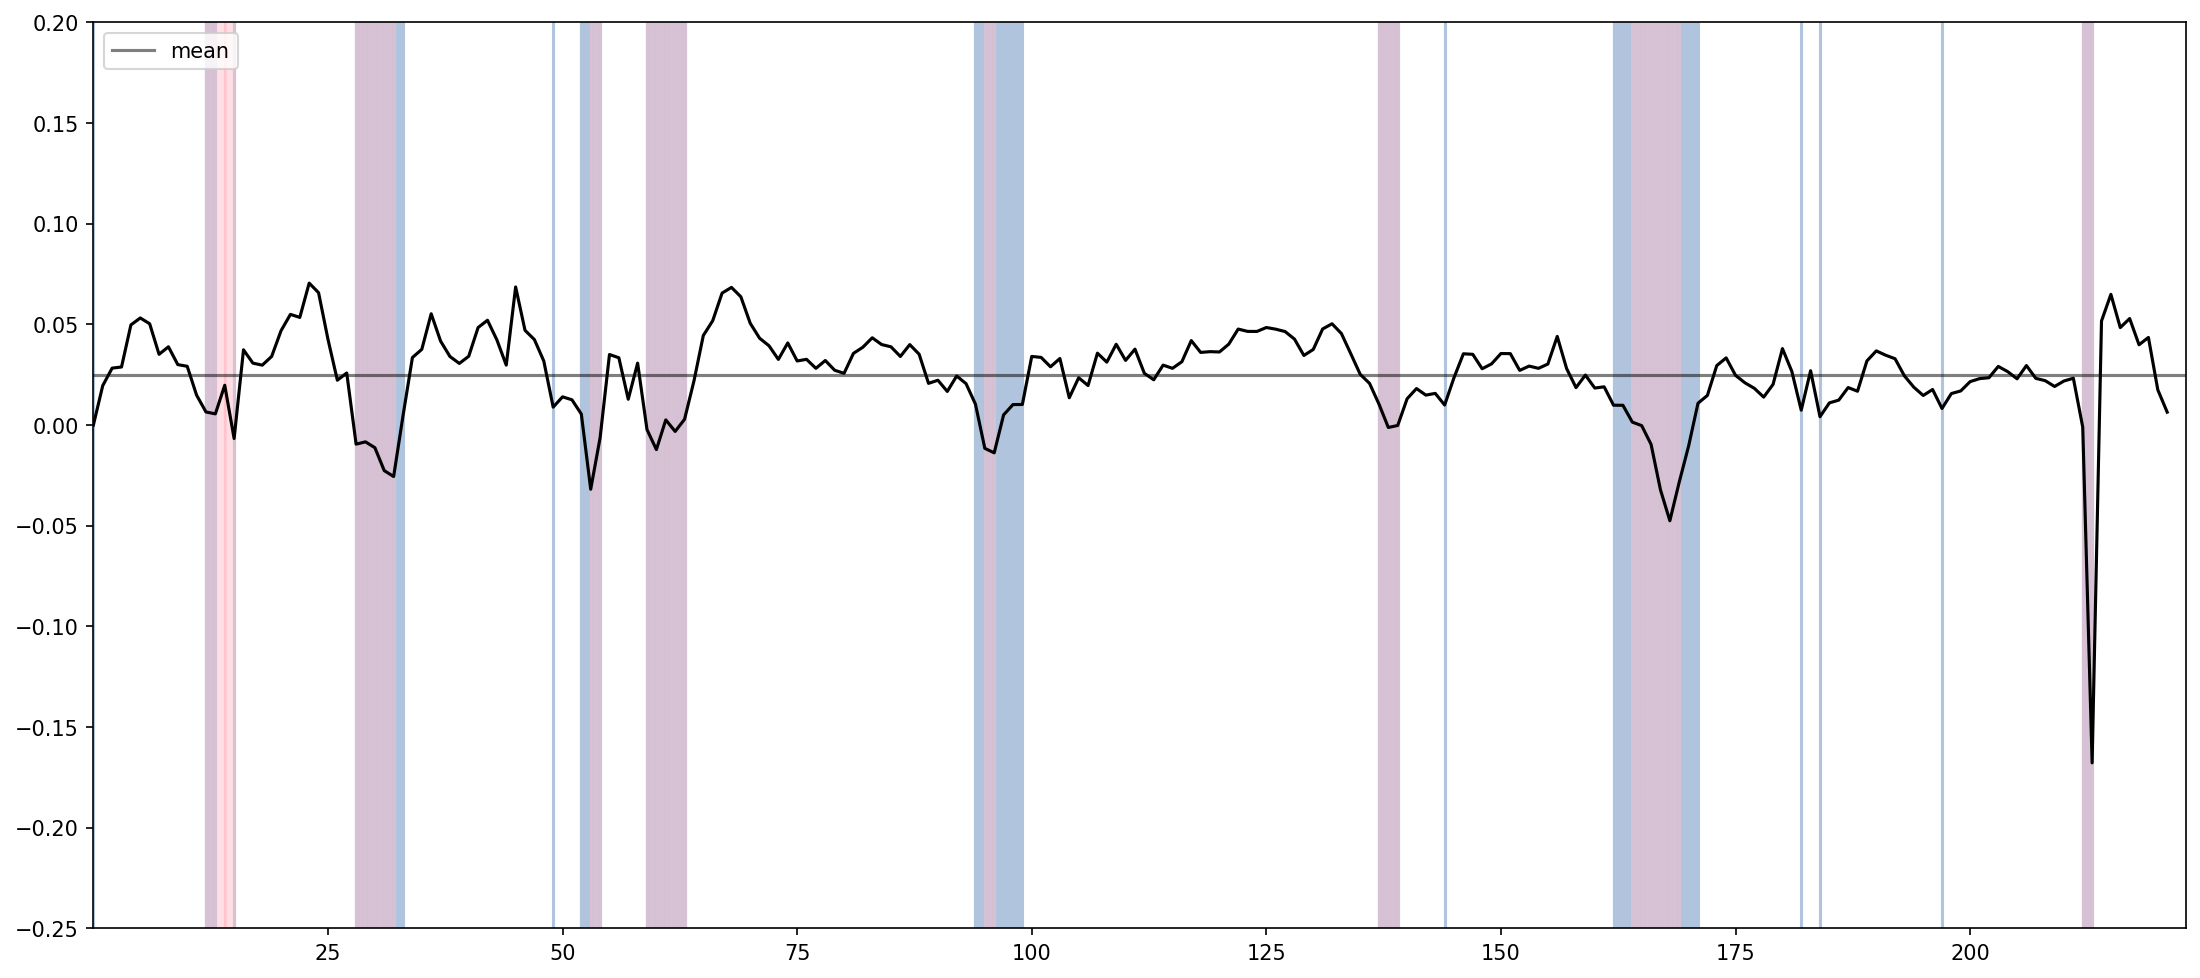

In [54]:
# 5 covariates
newdf = df.copy()
newdf = newdf[['log_real_personal_income_less_transfers', 'log_real_pce', 'log_real_gdp', 'log_real_gdi', 'log_real_avg_gdp_gdi']]
newdf = newdf.to_numpy()
newdf = np.delete(newdf, 0, 0)
y = newdf

G = np.ones((y.shape[1],1)) # vector of ones (k x 1)
x0 = np.array([[0]]) # n x 1 (so n = 1; scalar)
rho = np.array([[0.95]]) # n x 1 (scalar)
C = np.array([[0.05]]) # n x m (n=1 and chose m=1), where m is dimensionality of error term
R = 0.02*np.eye(y.shape[1]) # k x k 
sigma0 = np.array([[0.05]]) # n x n (so scalar)

new_k = Kalman(x0, sigma0, rho, C, G, R, y)
mnew, vnew = new_k.forecast()

new_k.plot_fig(plot_rhat=True) # Using my new plot function

In [55]:
# # Just using 5 covariates 
# plt.figure(figsize=(18, 8), dpi=150)
# ilist = list(range(df['nber_recessions'].shape[0]))
# for i in range(df['nber_recessions'].shape[0]):
#     if df['nber_recessions'][i] == 1:
#         plt.axvline(ilist[i], color = 'lightpink')
#         if df['nber_recessions'][i] == 1 and df['nber_recessions'][i+1] == 1:
#             y = np.arange(-0.5, 0.5, 0.01)
#             plt.fill_betweenx(y, ilist[i], ilist[i+1], color = 'lightpink')

# plt.plot(mnew, label= 'pce, gdp, gdi',  color='orangered') # also plotting the other one
# plt.axhline(mnew.mean(), label='mean for pce, gdp, gdi', color='orangered')
# plt.legend(loc='upper left')
# plt.xlim([0.01, df['nber_recessions'].shape[0]])
# plt.ylim([-0.25, 0.2])
# # plt.title('covariates used: log_real_manuf_trade_sales, log_emp_level, log_real_personal_income_less_transfers, log_real_pce, log_real_gdp, log_real_gdi, log_real_avg_gdp_gdi')
# plt.show() 

#### Now try using 7 covariates

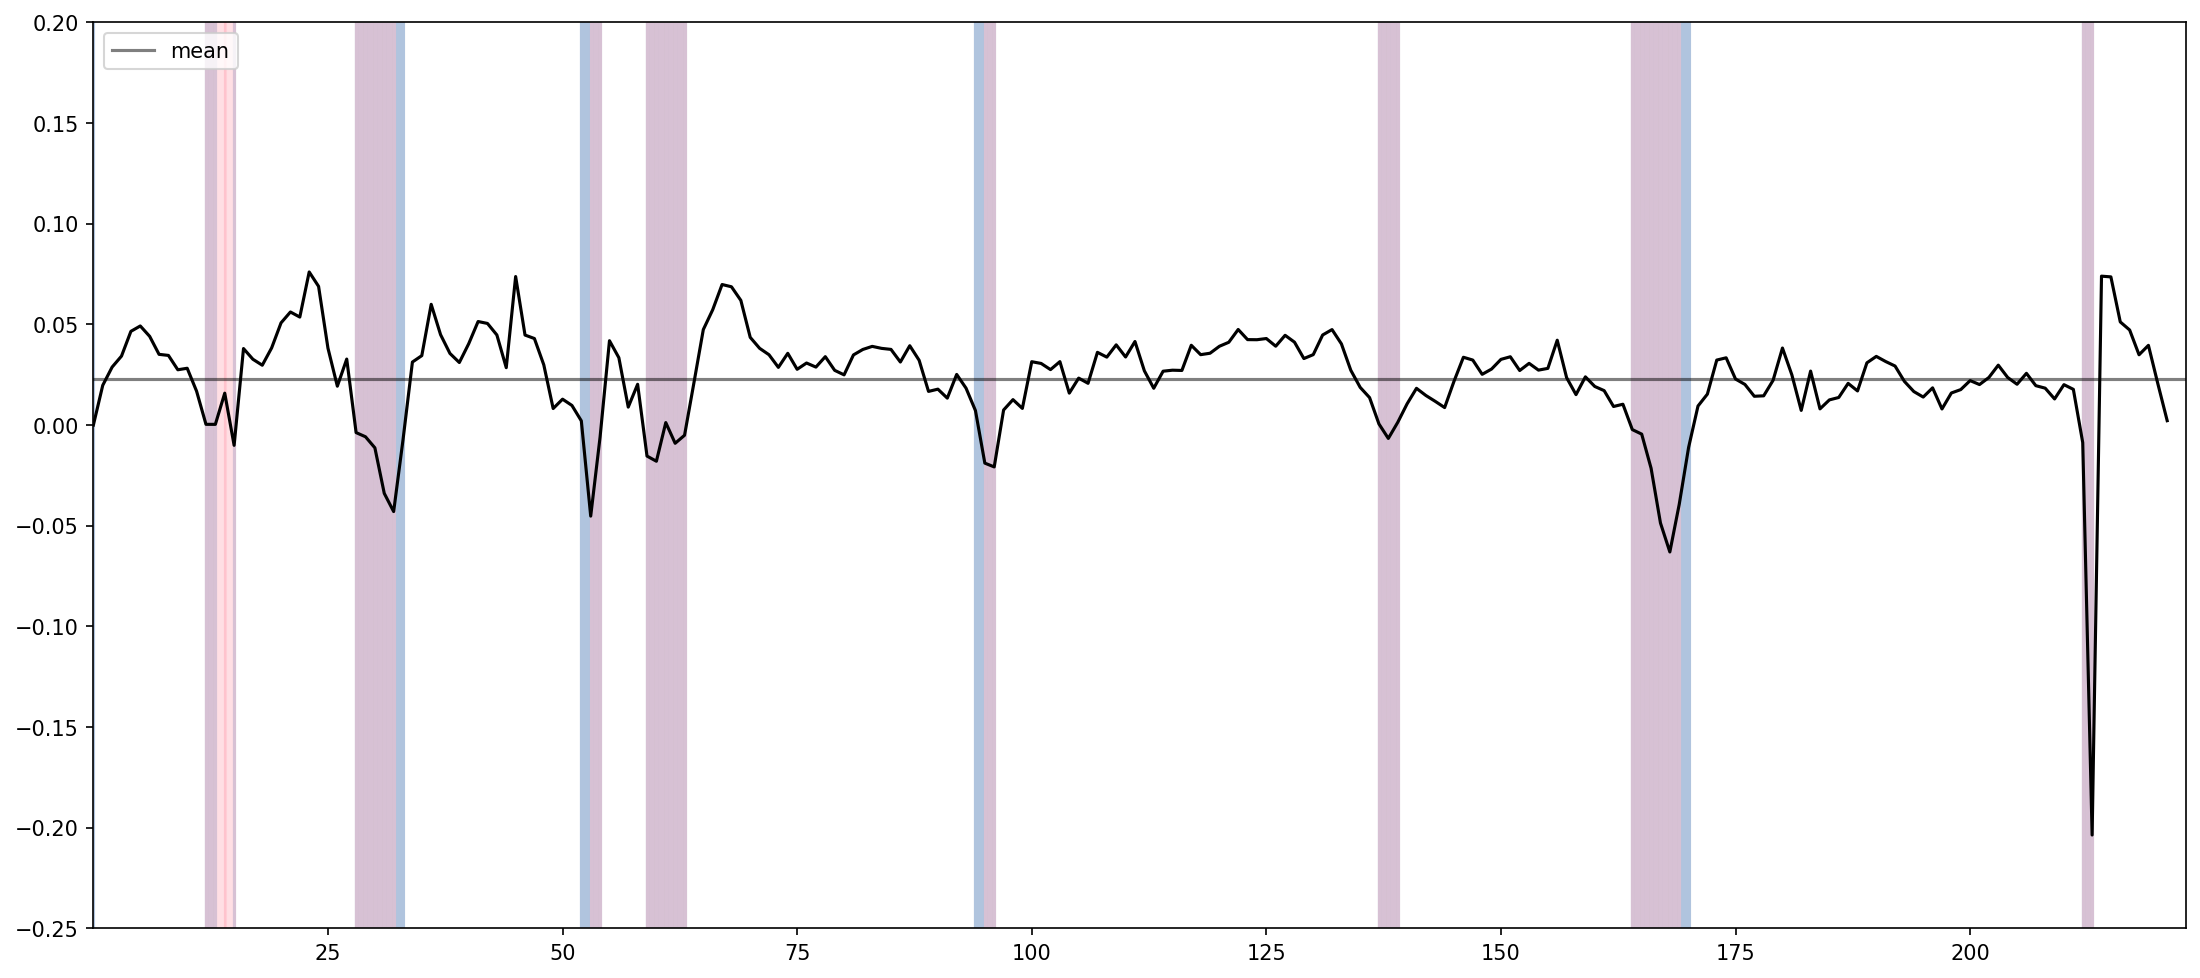

In [56]:
# 7 covariates
newdf2 = df.copy()
newdf2 = newdf2[['log_real_manuf_trade_sales','log_emp_level','log_real_personal_income_less_transfers', 'log_real_pce', 'log_real_gdp', 'log_real_gdi', 'log_real_avg_gdp_gdi']]

newdf2 = newdf2.to_numpy()
newdf2 = np.delete(newdf2, 0, 0) # first row NaNs
y = newdf2

G = np.ones((y.shape[1],1)) # vector of ones (k x 1)
x0 = np.array([[0]]) # n x 1 (so n = 1; scalar)
rho = np.array([[0.95]]) # n x 1 (scalar)
C = np.array([[0.05]]) # n x m (n=1 and chose m=1), where m is dimensionality of error term
R = 0.02*np.eye(y.shape[1]) # k x k 
sigma0 = np.array([[0.05]]) # n x n (so scalar)

new_k2 = Kalman(x0, sigma0, rho, C, G, R, y)
mnew2, vnew2 = new_k2.forecast()

new_k2.plot_fig(plot_rhat=True) # Using my new plot function


In [57]:
# # Just using 7 covariates
# plt.figure(figsize=(18, 8), dpi=150)
# ilist = list(range(df['nber_recessions'].shape[0]))
# for i in range(df['nber_recessions'].shape[0]):
#     if df['nber_recessions'][i] == 1:
#         plt.axvline(ilist[i], color = 'pink')
#         if df['nber_recessions'][i] == 1 and df['nber_recessions'][i+1] == 1:
#             y = np.arange(-0.5, 0.5, 0.01)
#             plt.fill_betweenx(y, ilist[i], ilist[i+1], color = 'pink')

# plt.plot(mnew2, label = 'pce, gdp, gdi, trade sales, emp vars', color='royalblue')
# plt.axhline(mnew2.mean(), label = 'mean for pce, gdp, gdi, trade sales, emp vars', color='royalblue')
# plt.legend(loc='upper left')
# plt.xlim([0.01, df['nber_recessions'].shape[0]])
# plt.ylim([-0.25, 0.2])
# # plt.title('covariates used: log_real_manuf_trade_sales, log_emp_level, log_real_personal_income_less_transfers, log_real_pce, log_real_gdp, log_real_gdi, log_real_avg_gdp_gdi')
# plt.show()

#### Plot 5 covariate $Y$ estimated $\hat{x}$  and 7 covariate $Y$ estimated $\hat{x}$ in same plot

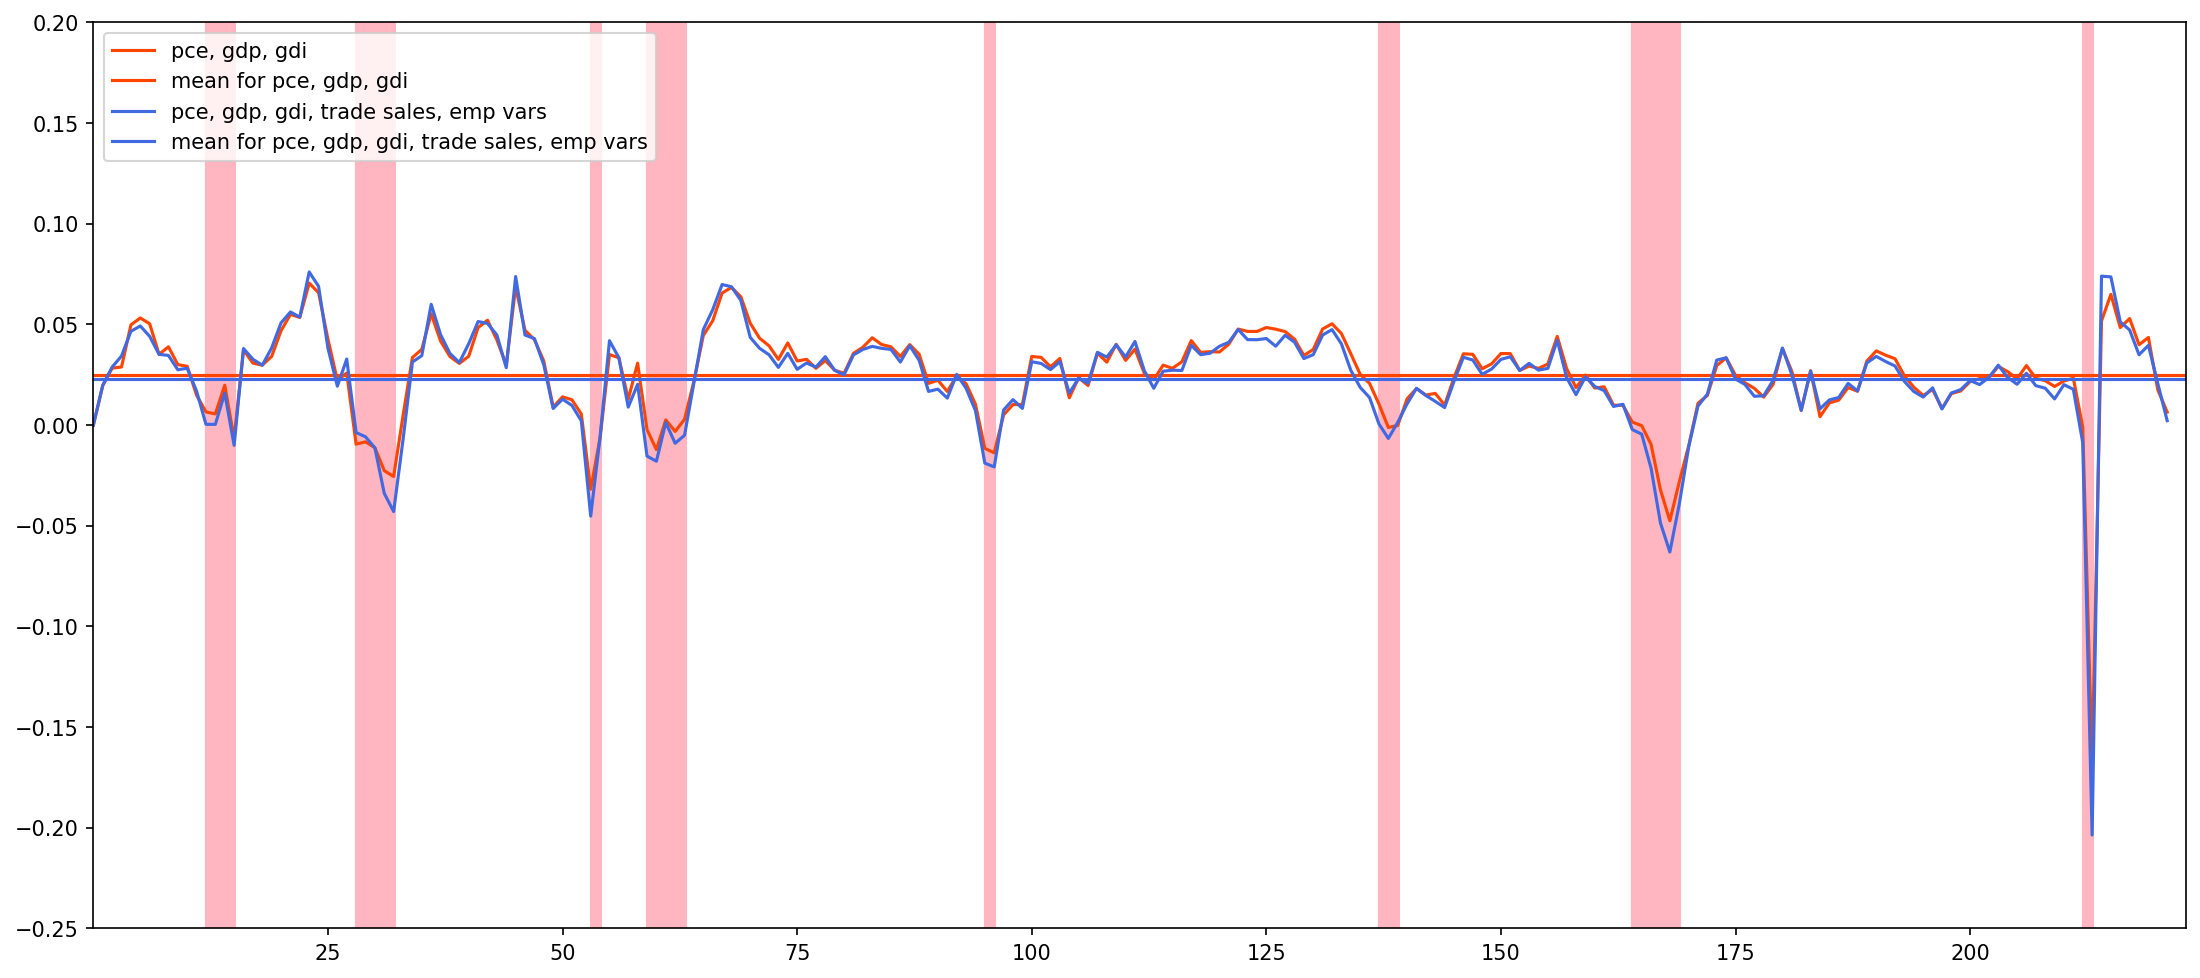

In [58]:
plt.figure(figsize=(18, 8), dpi=150)
# Plotting both 5 and 7 cases
ilist = list(range(df['nber_recessions'].shape[0]))
for i in range(df['nber_recessions'].shape[0]):
    if df['nber_recessions'][i] == 1:
        plt.axvline(ilist[i], color = 'lightpink')
        if df['nber_recessions'][i] == 1 and df['nber_recessions'][i+1] == 1:
            y = np.arange(-0.5, 0.5, 0.01)
            plt.fill_betweenx(y, ilist[i], ilist[i+1], color = 'lightpink')

plt.plot(mnew, label= 'pce, gdp, gdi', color='orangered') # also plotting the other one
plt.axhline(mnew.mean(), label='mean for pce, gdp, gdi', color='orangered')

plt.plot(mnew2, label = 'pce, gdp, gdi, trade sales, emp vars', color='royalblue')
plt.axhline(mnew2.mean(), label = 'mean for pce, gdp, gdi, trade sales, emp vars', color='royalblue')

plt.legend(loc='upper left')
plt.xlim([0.01, df['nber_recessions'].shape[0]])
plt.ylim([-0.25, 0.2])
# plt.title('covariates used: log_real_manuf_trade_sales, log_emp_level, log_real_personal_income_less_transfers, log_real_pce, log_real_gdp, log_real_gdi, log_real_avg_gdp_gdi')
plt.show()

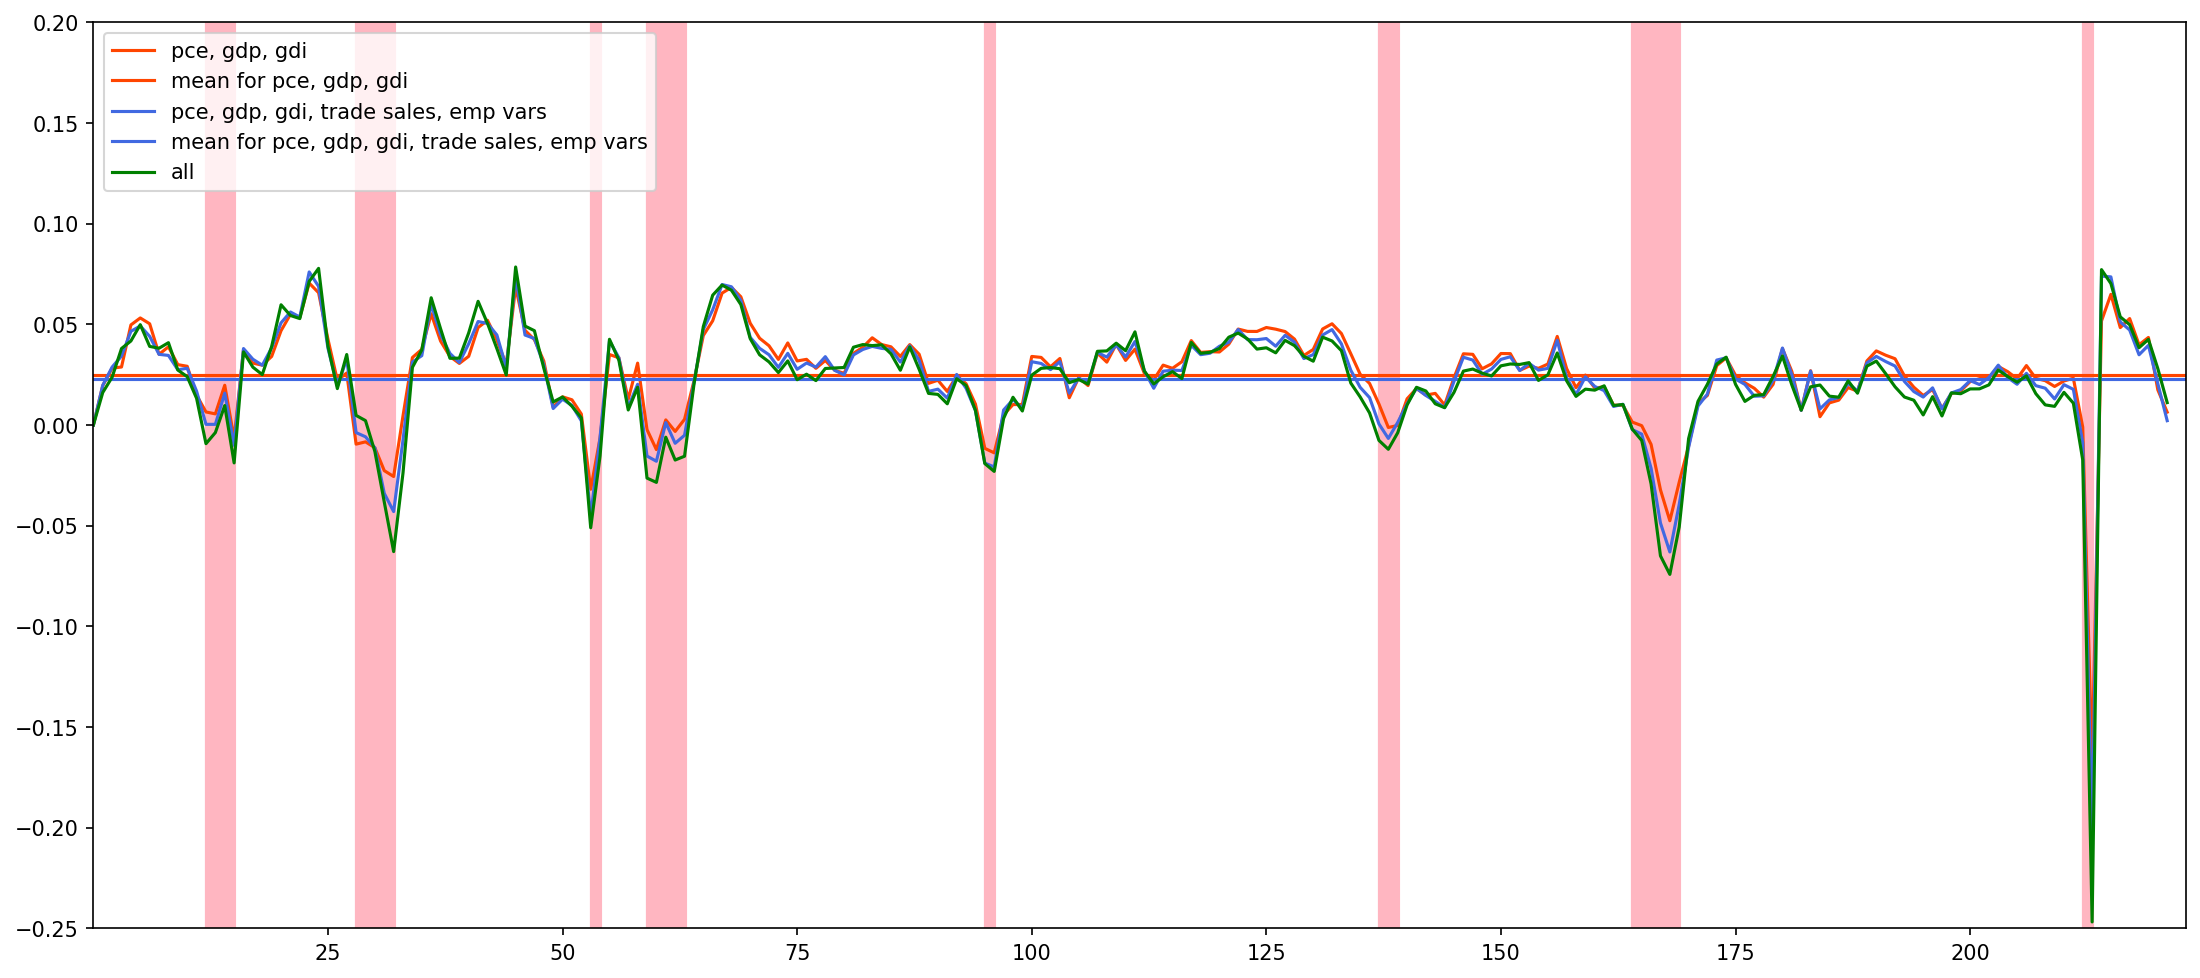

In [68]:
plt.figure(figsize=(18, 8), dpi=150)
# Plotting both 5 and 7 cases
ilist = list(range(df['nber_recessions'].shape[0]))
for i in range(df['nber_recessions'].shape[0]):
    if df['nber_recessions'][i] == 1:
        plt.axvline(ilist[i], color = 'lightpink')
        if df['nber_recessions'][i] == 1 and df['nber_recessions'][i+1] == 1:
            y = np.arange(-0.5, 0.5, 0.01)
            plt.fill_betweenx(y, ilist[i], ilist[i+1], color = 'lightpink')

# gamma = 0.3
# for i in range(mnew.shape[0]):
#     if mnew[i] < gamma*mnew.mean():
#         plt.axvline(ilist[i], color = 'gray',alpha=0.5)
#         if mnew[i] <= gamma*mnew.mean() and mnew[i-1] <= gamma*mnew.mean():
#             y = np.arange(-0.5, 0.5, 0.01)
#             plt.fill_betweenx(y, ilist[i], ilist[i+1], color = 'gray', alpha=0.5)

plt.plot(mnew, label= 'pce, gdp, gdi', color='orangered') # also plotting the other one
plt.axhline(mnew.mean(), label='mean for pce, gdp, gdi', color='orangered')

plt.plot(mnew2, label = 'pce, gdp, gdi, trade sales, emp vars', color='royalblue')
plt.axhline(mnew2.mean(), label = 'mean for pce, gdp, gdi, trade sales, emp vars', color='royalblue')
plt.plot(allvars_m, label='all', color = 'green')

plt.legend(loc='upper left')
plt.xlim([0.01, df['nber_recessions'].shape[0]])
plt.ylim([-0.25, 0.2])
# plt.title('covariates used: log_real_manuf_trade_sales, log_emp_level, log_real_personal_income_less_transfers, log_real_pce, log_real_gdp, log_real_gdi, log_real_avg_gdp_gdi')
plt.show()

#### Now try using a different parameter calibration with 7 covariate $Y$

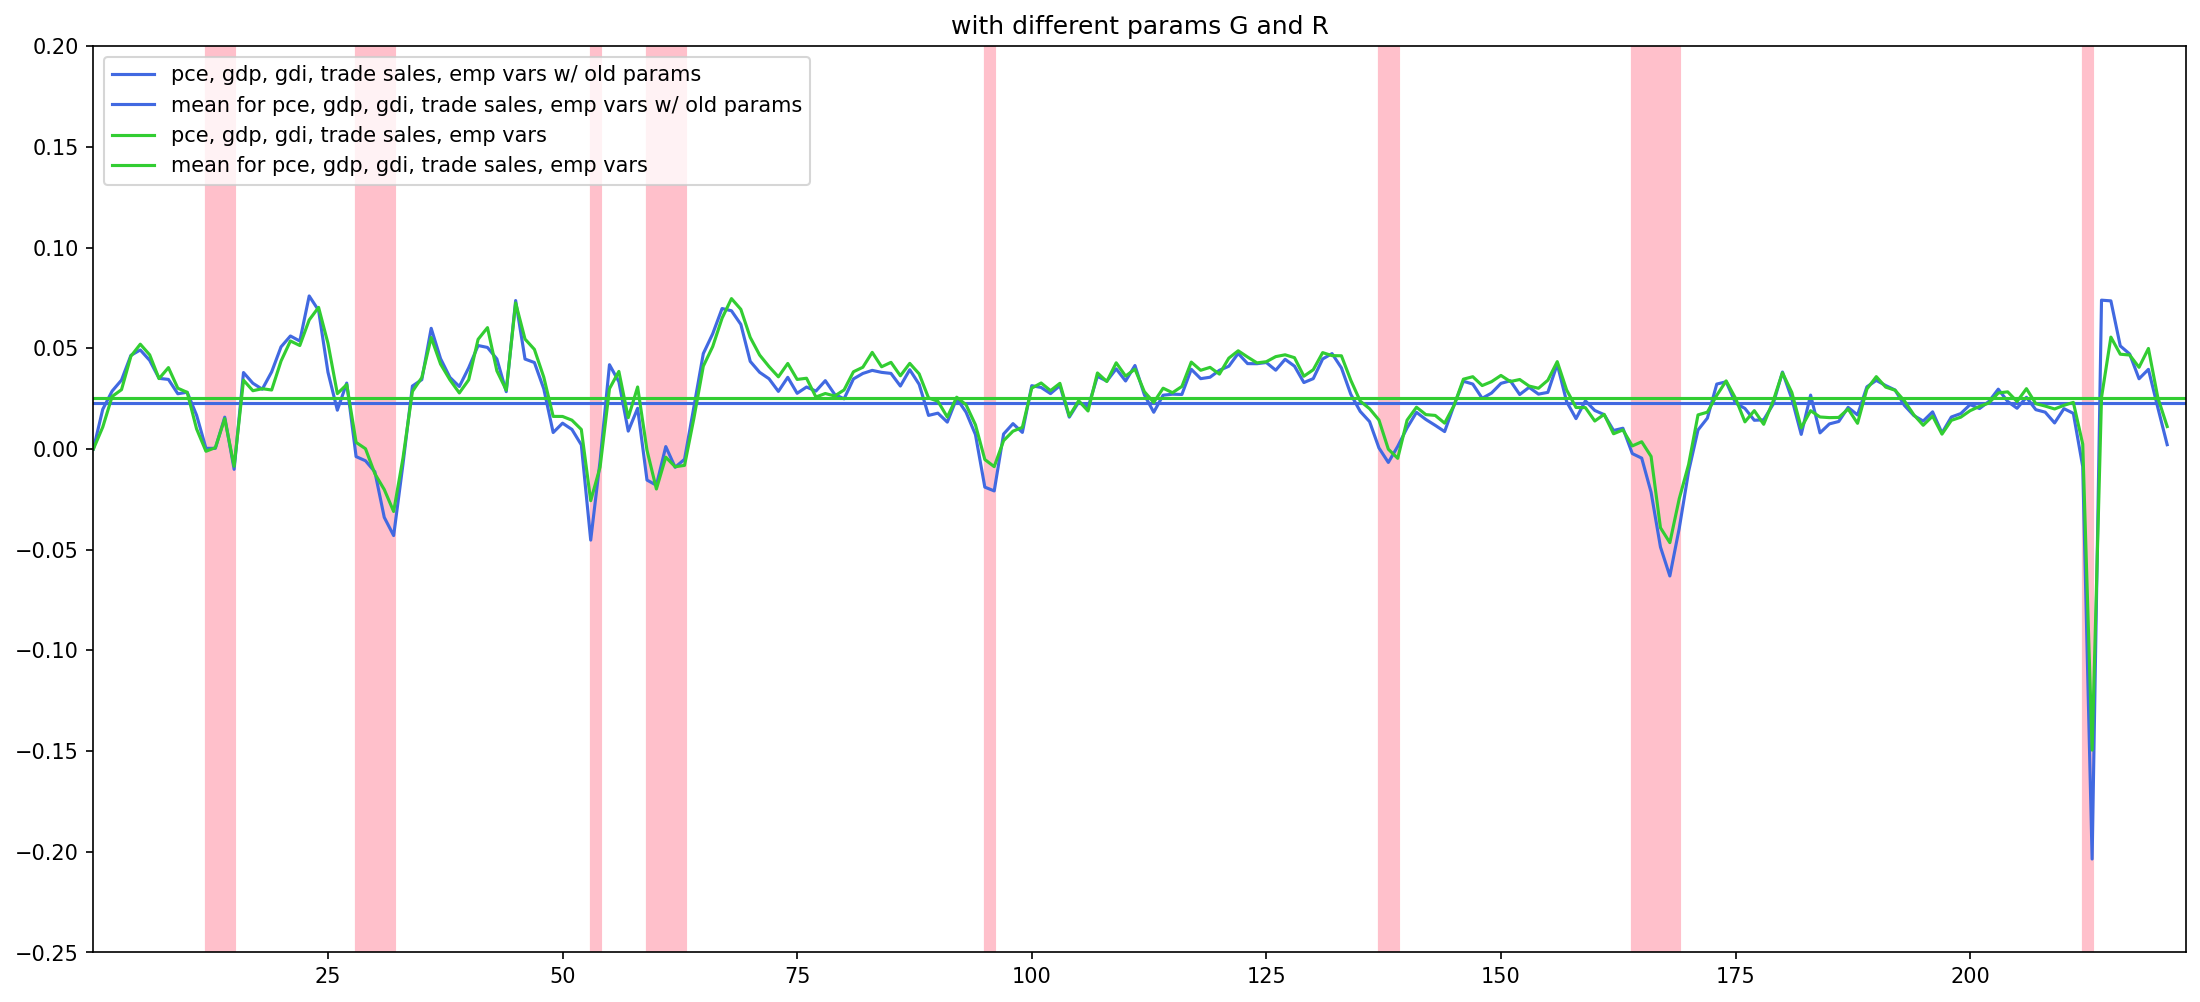

In [69]:
# Trying out a different paramterization with 7 covariates
plt.figure(figsize=(18, 8), dpi=150)
newdf = df.copy()
newdf = newdf[['log_real_personal_income_less_transfers', 'log_real_pce', 'log_real_gdp', 'log_real_gdi', 'log_real_avg_gdp_gdi']]

newdf = newdf.to_numpy()
newdf = np.delete(newdf, 0, 0) # first row NaNs
y = newdf

G = np.ones((y.shape[1],1)) # vector of ones (k x 1)
G[0] = 0.7 # me changing the original calibration 
G[1] = 0.2
G[2] = 0.95
G[3] = 0.95
G[4] = 0.95
x0 = np.array([[0]]) # n x 1 (so n = 1; scalar)
rho = np.array([[0.95]]) # n x 1 (scalar)

# rho = np.array([[1.5]]) # n x 1 (scalar)
C = np.array([[0.05]]) # n x m (n=1 and chose m=1), where m is dimensionality of error term
R = 0.02*np.eye(y.shape[1]) # k x k 
R[0,0] = 0.25 # me changing the original calibration 
R[1,1] = 0.73
R[2,2] = 0.02
R[3,3] = 0.02
R[4,4] = 0.02
sigma0 = np.array([[0.05]]) # n x n (so scalar)

new_kparams = Kalman(x0, sigma0, rho, C, G, R, y)
mnewparams, vnewparams = new_kparams.forecast()

ilist = list(range(df['nber_recessions'].shape[0]))
for i in range(df['nber_recessions'].shape[0]):
    if df['nber_recessions'][i] == 1:
        plt.axvline(ilist[i], color = 'pink')
        if df['nber_recessions'][i] == 1 and df['nber_recessions'][i+1] == 1:
            y = np.arange(-0.5, 0.5, 0.01)
            plt.fill_betweenx(y, ilist[i], ilist[i+1], color = 'pink')

plt.plot(mnew2, label= 'pce, gdp, gdi, trade sales, emp vars w/ old params', color='royalblue') # olds params
plt.axhline(mnew2.mean(), label = 'mean for pce, gdp, gdi, trade sales, emp vars w/ old params', color='royalblue')

plt.plot(mnewparams, label= 'pce, gdp, gdi, trade sales, emp vars', color='limegreen') # new params
plt.axhline(mnewparams.mean(), label='mean for pce, gdp, gdi, trade sales, emp vars', color='limegreen')

plt.legend(loc='upper left')
plt.xlim([0.01, df['nber_recessions'].shape[0]])
plt.ylim([-0.25, 0.2])
plt.title('with different params G and R')
plt.show()


Start with one variable for $y = Gx + \nu$ then change for another variable and then once what the code is doing is sensible, add more variables and start adjusting parameters

Misclassification search; search over the parameters wrt what $\hat{r}_t$'s they yield and use optimizer to pick the best one

## Next Steps: 
1. Using the error method ``calc_err`` for a fixed $\gamma$, loop through different choices of (logged) covariates from our initial dataframe, and choose covariate subset (which may the entire set) with the least total error (``np.sum(calc_err)``).
2. Choose optimal $\gamma$ by doing similar procedure with fixed set of covariates.
3. Choose optimal parameter calibration by doing similar procedure, keeping in mind the following: 
- General rule of thumb (from Jarda): (i) Higher $\sigma$, aka $C$, should correspond with a lower threshold $R$ (lower $\gamma$); (ii) Larger $[G]_{i}$ should correspond with lower $[R]_{ii}$, where $i$ denotes the $i$th covariate out of $K$ covariates, and vice versa. 
- Inverse relationship between $[G]_{i}$ and $[R]_{ii}$, i.e. (the $(i,i)$th component of the variance-covariance matrix for $\nu_t$ aka the $\mathbb{V}(y_t^{(i)})$ for $i \in \{1,...,K\}$, reflects how a covariate with more signal (more information) should also have less noise (less meaningless bits). 
- For the first comment about $C$ and threshold $R$, Jarda told me that we would discover this; I think this makes sense, since $C$ is the variance for $w_{t+1}$, and higher $C$ means that the unobservstate is harder to 
4. 

### STEP 4. Determine R, our recession threshold

### STEP 5. Using $\hat{x}_t, R$, construct $\hat{r}_t$ series, plot $\hat{r}_t$ and $r_t$